# Forecast Performance Analysis

This notebook evaluates model performance across different forecast lead times (1, 5, and 10 days) using NSE as the primary metric.

In [1]:
from transfer_learning_publication.evaluation import MetricCalculator
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 5)

## Load Predictions and Compute Metrics

Load all prediction parquet files from the evaluation results and compute NSE grouped by model, basin, and lead time.

In [ ]:
# Load predictions from all models
calc = MetricCalculator.from_parquet(
    "../results/evaluation/tajikistan_benchmark/model_name=*/seed=*/predictions.parquet"
)

# Compute NSE grouped by model, basin, and lead time
metrics = calc.compute_metrics(
    metrics=["nse"],
    group_by=["model_name", "group_identifier", "lead_time"],
    exclude_filled=True
)

print(f"Computed metrics for {metrics.height} combinations")
print(f"\nMetrics shape: {metrics.shape}")
metrics.head(10)

Computed metrics for 1960 combinations

Metrics shape: (1960, 4)


model_name,group_identifier,lead_time,NSE
str,str,i64,f64
"""ealstm""","""kyrgyzstan_15013""",1,0.976417
"""ealstm""","""kyrgyzstan_15013""",2,0.960937
"""ealstm""","""kyrgyzstan_15013""",3,0.94506
"""ealstm""","""kyrgyzstan_15013""",4,0.932591
"""ealstm""","""kyrgyzstan_15013""",5,0.922183
"""ealstm""","""kyrgyzstan_15013""",6,0.913859
"""ealstm""","""kyrgyzstan_15013""",7,0.904461
"""ealstm""","""kyrgyzstan_15013""",8,0.893784
"""ealstm""","""kyrgyzstan_15013""",9,0.885445


## Filter to Lead Times of Interest

Focus on lead times 1, 5, and 10 days to analyze performance degradation.

In [3]:
# Filter to lead times 1, 5, and 10
metrics_filtered = metrics.filter(
    pl.col("lead_time").is_in([1, 5, 10])
)

# Remove any NaN values for cleaner visualization
metrics_clean = metrics_filtered.filter(
    ~pl.col("NSE").is_nan()
)

print(f"Filtered metrics shape: {metrics_clean.shape}")
print(f"\nModels: {metrics_clean['model_name'].unique().sort().to_list()}")
print(f"Lead times: {metrics_clean['lead_time'].unique().sort().to_list()}")
print(f"Number of basins: {metrics_clean['group_identifier'].n_unique()}")

Filtered metrics shape: (588, 4)

Models: ['ealstm', 'tft', 'tide', 'tsmixer']
Lead times: [1, 5, 10]
Number of basins: 49


## Summary Statistics

Quick overview of NSE performance by model and lead time.

In [4]:
# Summary statistics
summary = (
    metrics_clean
    .group_by(["model_name", "lead_time"])
    .agg([
        pl.col("NSE").mean().alias("NSE_mean"),
        pl.col("NSE").median().alias("NSE_median"),
        pl.col("NSE").std().alias("NSE_std"),
        pl.count().alias("n_basins")
    ])
    .sort(["model_name", "lead_time"])
)

print(summary)

shape: (12, 6)
┌────────────┬───────────┬──────────┬────────────┬──────────┬──────────┐
│ model_name ┆ lead_time ┆ NSE_mean ┆ NSE_median ┆ NSE_std  ┆ n_basins │
│ ---        ┆ ---       ┆ ---      ┆ ---        ┆ ---      ┆ ---      │
│ str        ┆ i64       ┆ f64      ┆ f64        ┆ f64      ┆ u32      │
╞════════════╪═══════════╪══════════╪════════════╪══════════╪══════════╡
│ ealstm     ┆ 1         ┆ 0.980723 ┆ 0.990413   ┆ 0.026411 ┆ 49       │
│ ealstm     ┆ 5         ┆ 0.931231 ┆ 0.949989   ┆ 0.06527  ┆ 49       │
│ ealstm     ┆ 10        ┆ 0.88346  ┆ 0.906392   ┆ 0.09787  ┆ 49       │
│ tft        ┆ 1         ┆ 0.982238 ┆ 0.990791   ┆ 0.023684 ┆ 49       │
│ tft        ┆ 5         ┆ 0.941348 ┆ 0.958771   ┆ 0.055534 ┆ 49       │
│ …          ┆ …         ┆ …        ┆ …          ┆ …        ┆ …        │
│ tide       ┆ 5         ┆ 0.93336  ┆ 0.952547   ┆ 0.065339 ┆ 49       │
│ tide       ┆ 10        ┆ 0.8899   ┆ 0.912458   ┆ 0.090023 ┆ 49       │
│ tsmixer    ┆ 1         ┆ 0.972031 

/var/folders/9m/29m0bx0j0rsdyqb0b6yns28w0000gn/T/ipykernel_51546/1885234841.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_basins")


## Boxplot: NSE by Lead Time and Model

Visualize the distribution of NSE across basins for each model at each lead time.

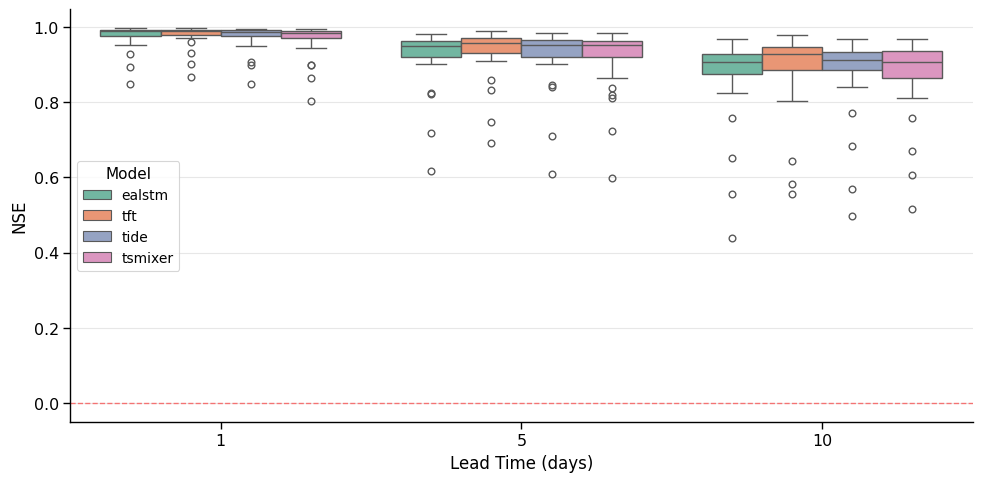

In [5]:
# Convert to pandas for seaborn compatibility
df_plot = metrics_clean.to_pandas()

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(
    data=df_plot,
    x="lead_time",
    y="NSE",
    hue="model_name",
    ax=ax,
    palette="Set2"
)

# Customize plot
ax.set_xlabel("Lead Time (days)", fontsize=12)
ax.set_ylabel("NSE", fontsize=12)
ax.legend(title="Model", fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add horizontal line at NSE=0 (baseline performance)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Baseline (NSE=0)')

plt.tight_layout()
sns.despine()
plt.show()